In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  mean_squared_error, mean_absolute_error, root_mean_squared_error

In [50]:
#random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [51]:
data = pd.read_csv('../data/processed_trips_2018.csv')
stations = pd.read_csv('../data/processed_stations_2018.csv')
weather = pd.read_csv('../data/weather_2018.csv')

We assign the station clusters to the start station ids because this is where the bikes are going to be picked up from 

In [52]:
data["station_cluster"] = data["start_station_id"].map(stations.set_index("station_id")["station_cluster"])

In [53]:
weather_cols = ["datetime","temp","feelslike","dew","humidity","precip","precipprob","snow","snowdepth","windgust","windspeed","sealevelpressure","visibility"]

In [54]:
weather_cleaned = weather[weather_cols]
weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])

#backfill missing weather data
weather_cleaned = weather_cleaned.sort_values('datetime').set_index('datetime').asfreq('h')
weather_cleaned = weather_cleaned.fillna(method='ffill')
weather_cleaned = weather_cleaned.reset_index()

weather_cleaned["day_of_week"] = weather_cleaned["datetime"].dt.dayofweek
weather_cleaned["hour_of_day"] = weather_cleaned["datetime"].dt.hour

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/2738095026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned['datetime'] = pd.to_datetime(weather_cleaned['datetime'])
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/2738095026.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_cleaned = weather_cleaned.fillna(method='ffill')


### Check how many bikes on average per hour per cluster

To select the best model to use, we first identify the busiest clusters.

In [55]:
bikes_per_day = data.groupby(['station_cluster', 'pickup_datetime']).size().reset_index(name='num_rentals')
avg_bikes_per_cluster = bikes_per_day.groupby('station_cluster')['num_rentals'].mean().sort_values(ascending=False).reset_index(name='avg_num_rentals')

In [56]:
cluster = data[data['station_cluster'] == avg_bikes_per_cluster.iloc[0]['station_cluster']]

## Creation of the time series data

In [57]:
hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')

In [58]:
hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])

In [59]:
hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']
hourly_cluster

,datetime,num_rentals_pickups,num_rentals_dropoffs
0,2018-01-01 00:00:00,18.0,14.0
1,2018-01-01 01:00:00,30.0,29.0
2,2018-01-01 02:00:00,11.0,16.0
3,2018-01-01 03:00:00,9.0,6.0
4,2018-01-01 04:00:00,2.0,5.0
...,...,...,...
8723,2018-12-31 19:00:00,20.0,21.0
8724,2018-12-31 20:00:00,28.0,30.0
8725,2018-12-31 21:00:00,7.0,8.0
8726,2018-12-31 22:00:00,9.0,11.0


### We ensure each timestamp gets a row

In [60]:
print(f'size of hourly_cluster: {hourly_cluster.shape}')
def fill_missing_hours(df):
    all_hours = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='h')
    all_hours_df = pd.DataFrame({'datetime': all_hours})
    all_hours_df["datetime"] = pd.to_datetime(all_hours_df["datetime"])
    merged_df = pd.merge(all_hours_df, df, on=['datetime'], how='left')
    merged_df['num_rentals_pickups'] = merged_df['num_rentals_pickups'].fillna(0).astype(int)
    merged_df['num_rentals_dropoffs'] = merged_df['num_rentals_dropoffs'].fillna(0).astype(int)

    return merged_df

hourly_cluster = fill_missing_hours(hourly_cluster)
print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


## Initial Exploration of the dataset

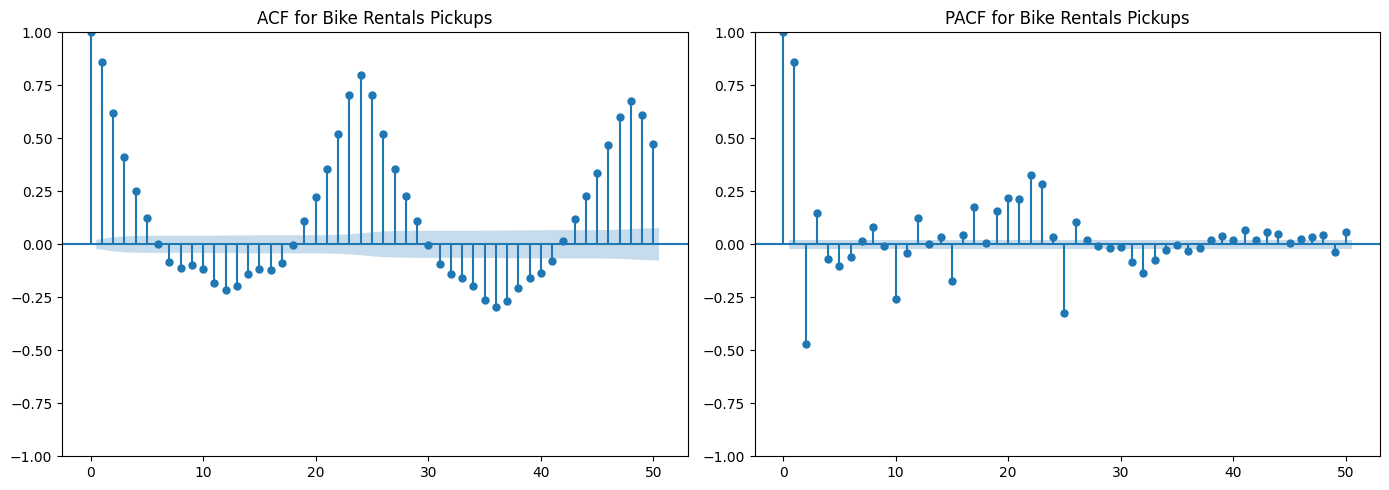

In [61]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=50, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f'ACF {title_suffix}')
    
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm') 
    axes[1].set_title(f'PACF {title_suffix}')
    
    plt.tight_layout()
    plt.show()
plot_acf_pacf(hourly_cluster['num_rentals_pickups'], lags=50, title_suffix='for Bike Rentals Pickups')

ACF: decays slowly, crosses significance after lag 5, then rises at multiples of 24 hours.

PACF: significant at lag 0 and 1 positive, lag 2 negative, then essentially small values.

Slow decay in ACF → indicates strong autocorrelation / possible AR component.

PACF spikes at lag 1 → suggests AR(1) term is relevant.

ACF peaks at multiples of 24 hours → indicates daily seasonality (hourly data).

Beyond lag 5, ACF is mostly noise → MA terms may be limited to small lags.

## Train Time Series

In [140]:
##CONSTANTS
END_TRAINING_DATE = pd.to_datetime("2018-09-01 00:00:00")
END_VALIDATION_DATE = pd.to_datetime("2018-11-01 00:00:00")

## Split train - Test

In [141]:
train_data = hourly_cluster[hourly_cluster['datetime'] < END_VALIDATION_DATE].set_index('datetime')
test_data = hourly_cluster[hourly_cluster['datetime'] >= END_VALIDATION_DATE].set_index('datetime')

train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

train_weather  = weather_cleaned[weather_cleaned['datetime'] < END_VALIDATION_DATE].set_index('datetime')
test_weather   = weather_cleaned[weather_cleaned['datetime'] >= END_VALIDATION_DATE].set_index('datetime')

train_weather.index = pd.to_datetime(train_weather.index)
test_weather.index  = pd.to_datetime(test_weather.index)

In [142]:
train_data = train_data.asfreq('h')
test_data = test_data.asfreq('h')

train_weather = train_weather.asfreq('h')
test_weather = test_weather.asfreq('h')

In [143]:
train_exog = train_weather[['temp','feelslike','humidity','precip','precipprob','snowdepth','windspeed','visibility']]
test_exog = test_weather[['temp','feelslike','humidity','precip','precipprob','snowdepth','windspeed','visibility']]

In [ ]:
def print_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    return mae, rmse

# def plot_predictions_vs_true(test_data, predicted_column, true_column):
#         plt.figure(figsize=(15, 6))
#         plt.plot(test_data.index, test_data[true_column], label='Actual', color='blue')
#         plt.plot(test_data.index, test_data[predicted_column], label='Predicted', color='orange')
#         plt.xlabel('Datetime')
#         plt.ylabel('Number of Rentals')
#         plt.title('ARIMA Model: Actual vs Predicted Number of Rentals')
#         plt.legend()
#         plt.show()

def plot_predictions_vs_true(predicted_values, true_values):
    plt.figure(figsize=(15, 6))
    plt.plot(true_values, label='Actual', linewidth=2)
    plt.plot(predicted_values, label='Predicted', linewidth=2)
    plt.xlabel('Index')
    plt.ylabel('Number of Rentals')
    plt.title('Actual vs Predicted Number of Rentals')
    plt.legend()
    plt.show()


In [71]:
PICKUP_TARGET_COL = 'num_rentals_pickups'
DROPOFF_TARGET_COL = 'num_rentals_dropoffs'

In [72]:
performance_pickup = {}
performance_dropoffs= {}

# PREDICTIONS

This fold_config is used to run a cross validation time series with two folds. The best model selected will be the one with the lowers average MAE between folds

In [74]:
folds_config = [
    {'train_start': pd.Timestamp('2018-01-01 00:00:00'), 
     'train_end': pd.Timestamp('2018-06-30 23:00:00'),
     'val_start': pd.Timestamp('2018-07-01 00:00:00'), 
     'val_end': pd.Timestamp('2018-08-31 23:00:00')},
    {'train_start': pd.Timestamp('2018-01-01 00:00:00'), 
     'train_end': pd.Timestamp('2018-08-31 23:00:00'),
     'val_start': pd.Timestamp('2018-09-01 00:00:00'), 
     'val_end': pd.Timestamp('2018-10-31 23:00:00')}
]

## Predictions Utils

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarimax_fit_predict_folds_daily(folds_config, train_data, target, order, s_order, exog=None):
    """
    Fits a sarima or sarimax model (if exog) for each fold in the cross validation
    and predicts only at midnight for the next 24 hours
    """    
    maes = []
    rmses= []
    for i, fold in enumerate(folds_config, 1):
        trues= []
        preds = []
        train_fold = train_data.loc[fold['train_start']:fold['train_end']]
        val_fold   = train_data.loc[fold['val_start']:fold['val_end']].copy()

        val_fold_midnight = val_fold[val_fold.index.hour == 0]

        if exog is not None:
            exog_train = exog.loc[fold['train_start']:fold['train_end']]
            exog_val   = exog.loc[val_fold_midnight.index[0]:val_fold_midnight.index[-1]+pd.Timedelta(hours=23)]
        else:
            exog_train = None
            exog_val = None

        # Fit SARIMAX
        model = SARIMAX(
            train_fold[target],
            exog=exog_train,
            order=order,
            seasonal_order=s_order,
            enforce_stationarity=True,
            enforce_invertibility=True
        )
        model_fit = model.fit(disp=False)

        for start_time in val_fold_midnight.index:
            end_time = start_time + pd.Timedelta(hours=23)
            if exog_val is not None:
                exog_slice = exog_val.loc[start_time:end_time]
            else:
                exog_slice = None

            pred = model_fit.forecast(steps=24, exog=exog_slice)
            pred = np.clip(pred.values, 0, None)

            true = val_fold.loc[start_time:end_time, target]

            trues.append(true)
            preds.append(pd.Series(pred, index=true.index))
        
        trues = pd.concat(trues)
        preds = pd.concat(preds)
        if i == 2:
            print(f"Fold {i} SARIMAX summary:")
            print(model_fit.summary())
            plot_predictions_vs_true(preds, trues)

        mae_fold, rmse_fold = print_metrics(trues, preds)
        maes.append(mae_fold)
        rmses.append(rmse_fold)

    avg_mae = np.round(np.mean(maes),2)
    avg_rmse = np.round(np.mean(rmses),2)
    return avg_mae, avg_rmse


def sarimax_fit_predict(train_data, test_data, target, order, s_order, new_col, exog_train=None, exog_test=None):
    """ Fits a sarima or sarimax model (if exog) and predicts only at midnight for the next 24 hours """ 
    model = SARIMAX(
        train_data[target],
        exog=exog_train,
        order=order,             
        seasonal_order=s_order, 
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    print(model_fit.summary())

    trues = []
    preds = []

    test_midnight = test_data[test_data.index.hour == 0]

    for start_time in test_midnight.index:
        end_time = start_time + pd.Timedelta(hours=23)
        if exog_test is not None:
            exog_slice = exog_test.loc[start_time:end_time]
        else:
            exog_slice = None

        # Forecast next 24 hours
        pred = model_fit.forecast(steps=24, exog=exog_slice)
        pred = np.clip(pred.values, 0, None)

        # True values
        true = test_data.loc[start_time:end_time, target]

        trues.append(true)
        preds.append(pd.Series(pred, index=true.index))

    # Concatenate all days
    trues = pd.concat(trues)
    preds = pd.concat(preds)

    # Compute metrics
    mae, rmse = print_metrics(trues, preds)

    # Plot predictions vs true values
    df_plot = pd.DataFrame({
        'Actual': trues,
        'Predicted': preds
    })
    plot_predictions_vs_true(df_plot["Predicted"], df_plot['Actual'])

    return mae, rmse


# 1. First Approach: given the ACF and PACF we try a SARIMA model

Prediciting num_rentals_pickups
Fold 1 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:                num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -23941.092
Date:                            Mon, 01 Dec 2025   AIC                          47890.185
Time:                                    09:43:16   BIC                          47915.668
Sample:                                01-01-2018   HQIC                         47899.183
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1212      0.045     -2.721      0.007    

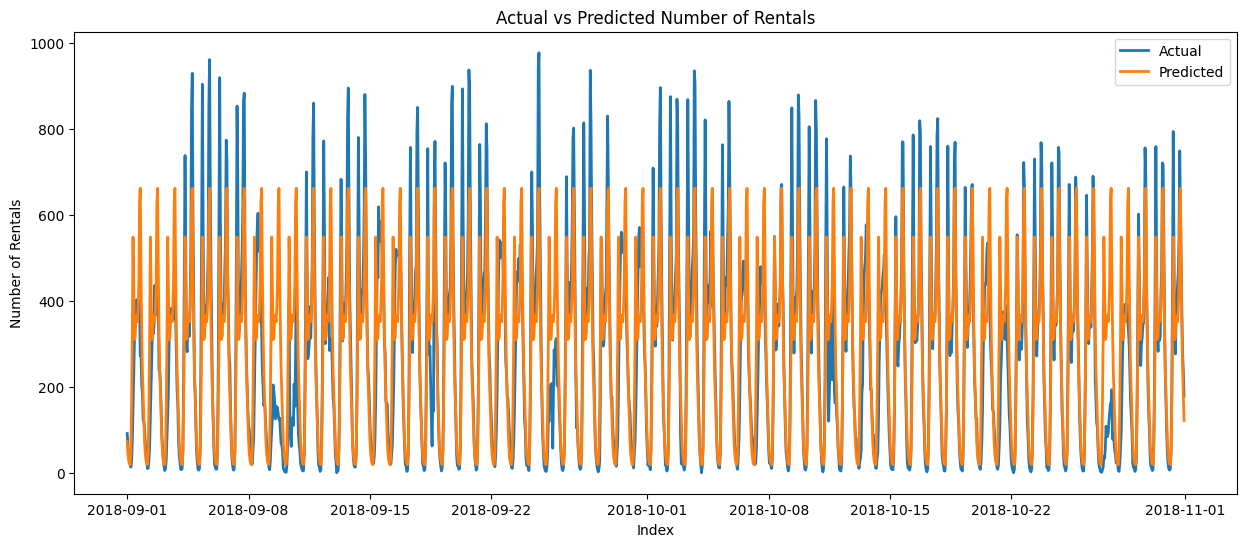

Mean Absolute Error (MAE): 81.73
Root Mean Squared Error (RMSE): 122.67
Prediciting num_rentals_dropoffs
Fold 1 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:               num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -23710.775
Date:                            Mon, 01 Dec 2025   AIC                          47429.551
Time:                                    09:44:07   BIC                          47455.034
Sample:                                01-01-2018   HQIC                         47438.549
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

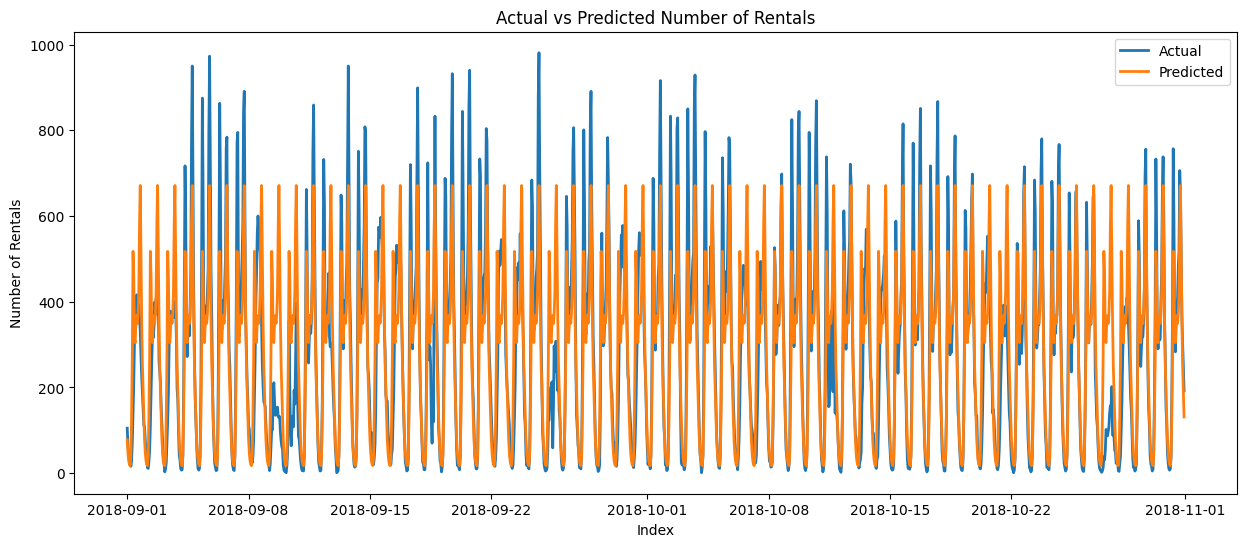

Mean Absolute Error (MAE): 81.1
Root Mean Squared Error (RMSE): 121.21


In [93]:
order=(1,1,1)
s_order=(0,1,1,24)

print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order)
performance_pickup["model_sarima"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order)
performance_dropoffs["model_sarima"] = {"val_mae": mae, "val_rmse": rmse}

## 2. We add exogenous weather variables

Prediciting num_rentals_pickups


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:                num_rentals_pickups   No. Observations:                 4344
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -23920.067
Date:                            Mon, 01 Dec 2025   AIC                          47870.133
Time:                                    09:50:14   BIC                          47965.695
Sample:                                01-01-2018   HQIC                         47903.876
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                 7.5011      3.290      2.280      0.023       1.053      

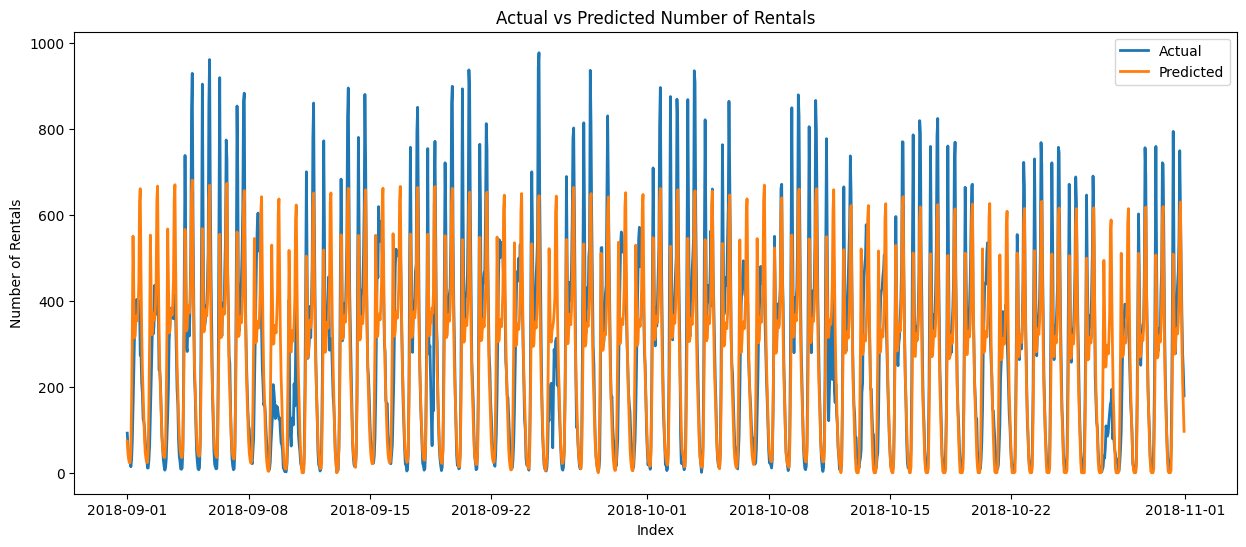

Mean Absolute Error (MAE): 83.89
Root Mean Squared Error (RMSE): 121.83
Prediciting num_rentals_dropoffs


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 1 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:               num_rentals_dropoffs   No. Observations:                 4344
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -23675.754
Date:                            Mon, 01 Dec 2025   AIC                          47381.507
Time:                                    10:00:12   BIC                          47477.069
Sample:                                01-01-2018   HQIC                         47415.249
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                 5.6532      3.076      1.838      0.066      -0.376      

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:               num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -32261.356
Date:                            Mon, 01 Dec 2025   AIC                          64552.711
Time:                                    10:07:11   BIC                          64652.713
Sample:                                01-01-2018   HQIC                         64587.496
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp                 4.6023      2.953      1.558      0.119      -1.186      

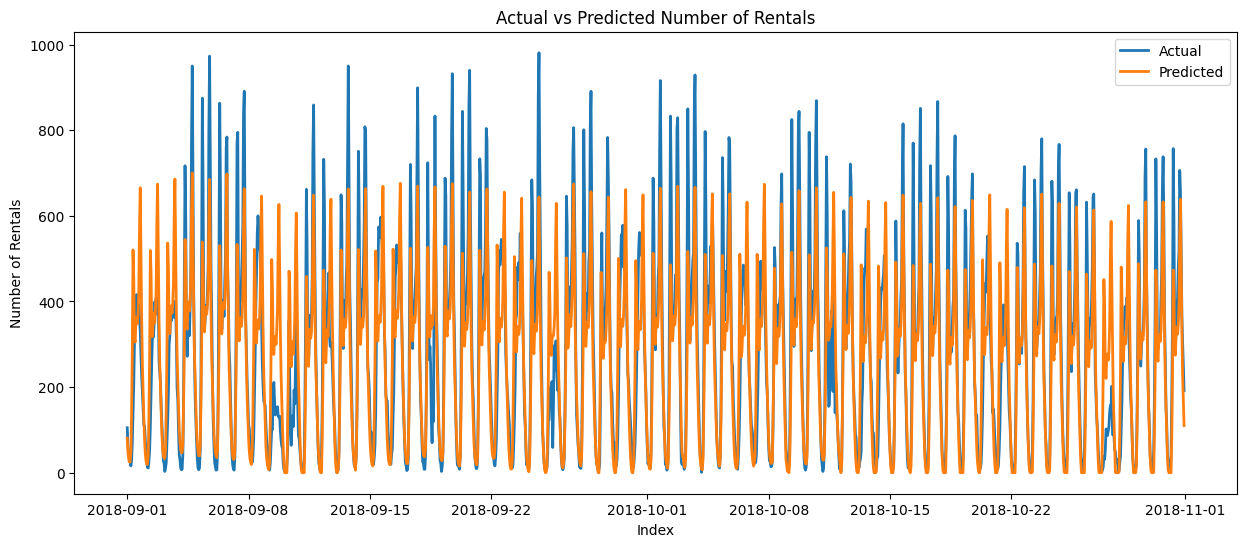

Mean Absolute Error (MAE): 83.26
Root Mean Squared Error (RMSE): 119.34


In [94]:
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog)
performance_pickup["model_sarimax"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog)
performance_dropoffs["model_sarimax"] = {"val_mae": mae, "val_rmse": rmse}

### 3. We keep only the relevant exogenous variables

In [97]:
train_exog_short = train_exog[['precip','visibility']]
test_exog_short = test_exog[['precip','visibility']]

Prediciting num_rentals_pickups
Mean Absolute Error (MAE): 72.09
Root Mean Squared Error (RMSE): 111.41
Fold 2 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:                num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -32543.767
Date:                            Mon, 01 Dec 2025   AIC                          65099.533
Time:                                    10:10:50   BIC                          65139.534
Sample:                                01-01-2018   HQIC                         65113.448
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

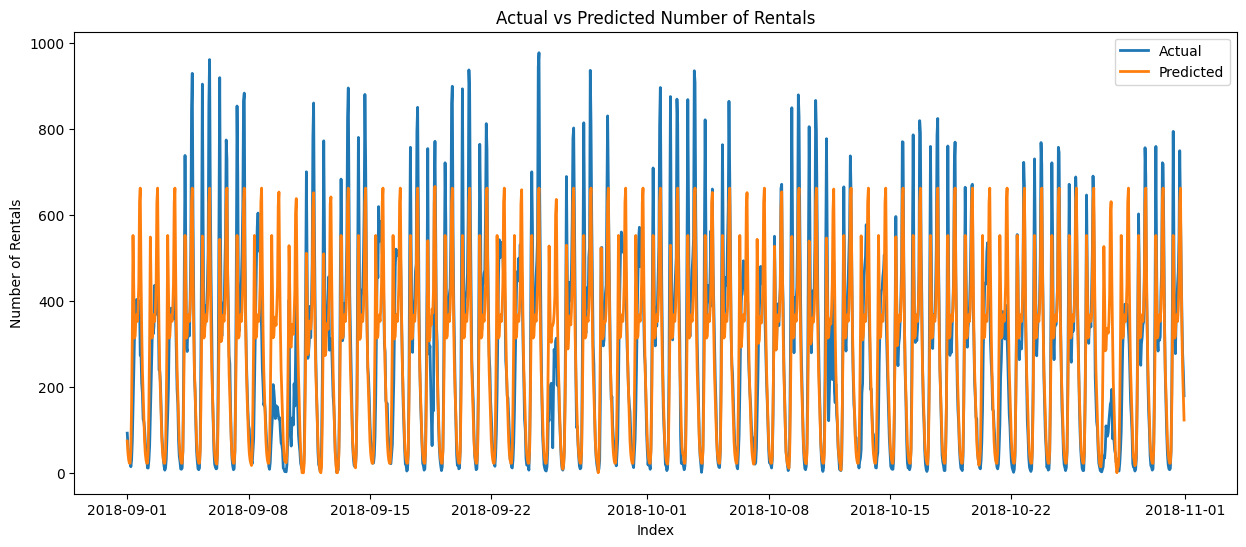

Mean Absolute Error (MAE): 81.04
Root Mean Squared Error (RMSE): 121.42
Prediciting num_rentals_dropoffs
Mean Absolute Error (MAE): 69.17
Root Mean Squared Error (RMSE): 108.71
Fold 2 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:               num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -32267.510
Date:                            Mon, 01 Dec 2025   AIC                          64547.021
Time:                                    10:13:01   BIC                          64587.022
Sample:                                01-01-2018   HQIC                         64560.935
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025     

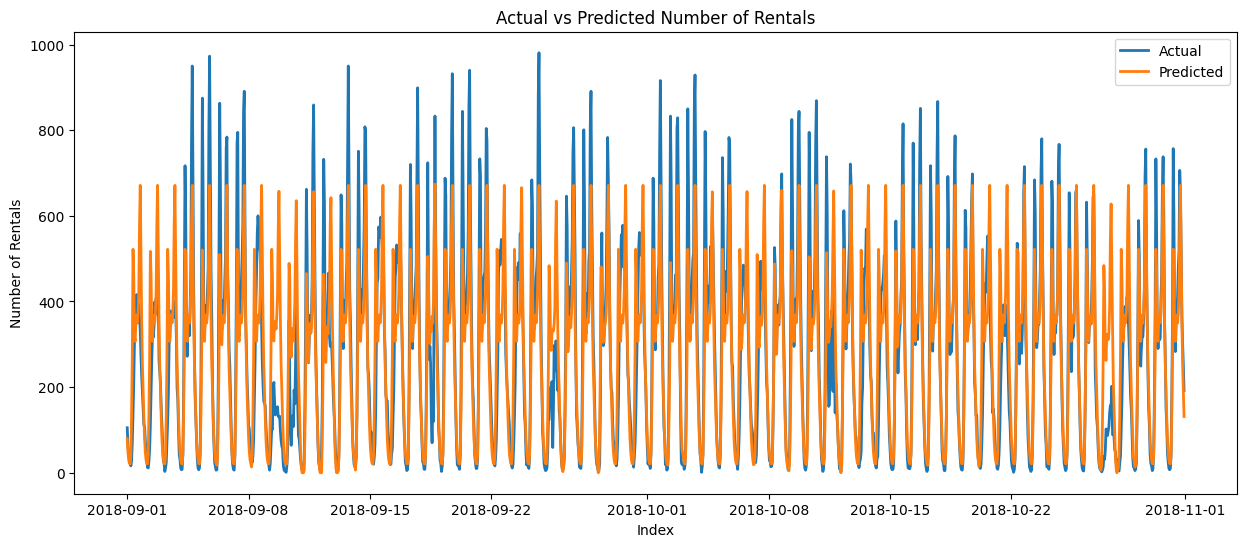

Mean Absolute Error (MAE): 80.12
Root Mean Squared Error (RMSE): 119.29


In [98]:
print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog_short)
performance_pickup["model_sarimax_short"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog_short)
performance_dropoffs["model_sarimax_short"] = {"val_mae": mae, "val_rmse": rmse}

## 4. Adding day and hour

/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/1868882519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_exog_w_date['hour_sin'] = np.sin(2 * np.pi * train_exog_w_date['hour_of_day'] / 24)
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/1868882519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_exog_w_date['hour_cos'] = np.cos(2 * np.pi * train_exog_w_date['hour_of_day'] / 24)
/var/folders/c6/k78nzngn7nbdd0786bxl3s0c0000gn/T/ipykernel_46030/1868882519.

Prediciting num_rentals_pickups
Mean Absolute Error (MAE): 71.1
Root Mean Squared Error (RMSE): 109.85
Fold 2 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:                num_rentals_pickups   No. Observations:                 5832
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -32543.690
Date:                            Mon, 01 Dec 2025   AIC                          65107.381
Time:                                    10:19:11   BIC                          65174.049
Sample:                                01-01-2018   HQIC                         65130.571
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

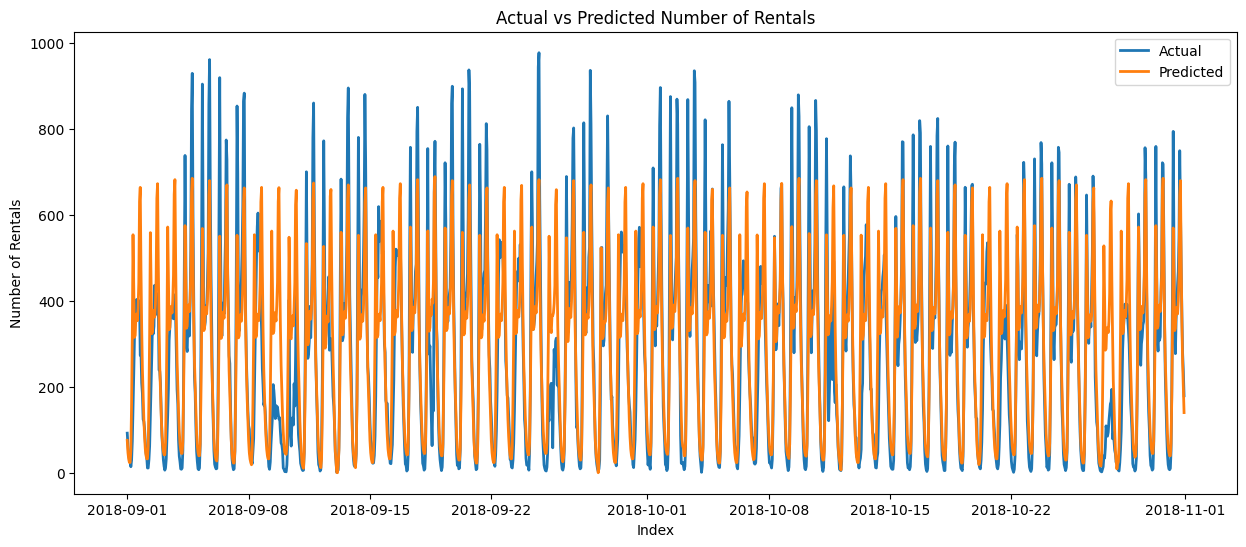

Mean Absolute Error (MAE): 81.92
Root Mean Squared Error (RMSE): 121.48
Prediciting num_rentals_dropoffs


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 69.28
Root Mean Squared Error (RMSE): 107.75


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2 SARIMAX summary:
                                     SARIMAX Results                                      
Dep. Variable:               num_rentals_dropoffs   No. Observations:                 5832
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 24)   Log Likelihood              -32266.807
Date:                            Mon, 01 Dec 2025   AIC                          64553.615
Time:                                    10:26:52   BIC                          64620.283
Sample:                                01-01-2018   HQIC                         64576.805
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
precip         1.7846      0.376      4.746      0.000       1.048       2.522
visibility 

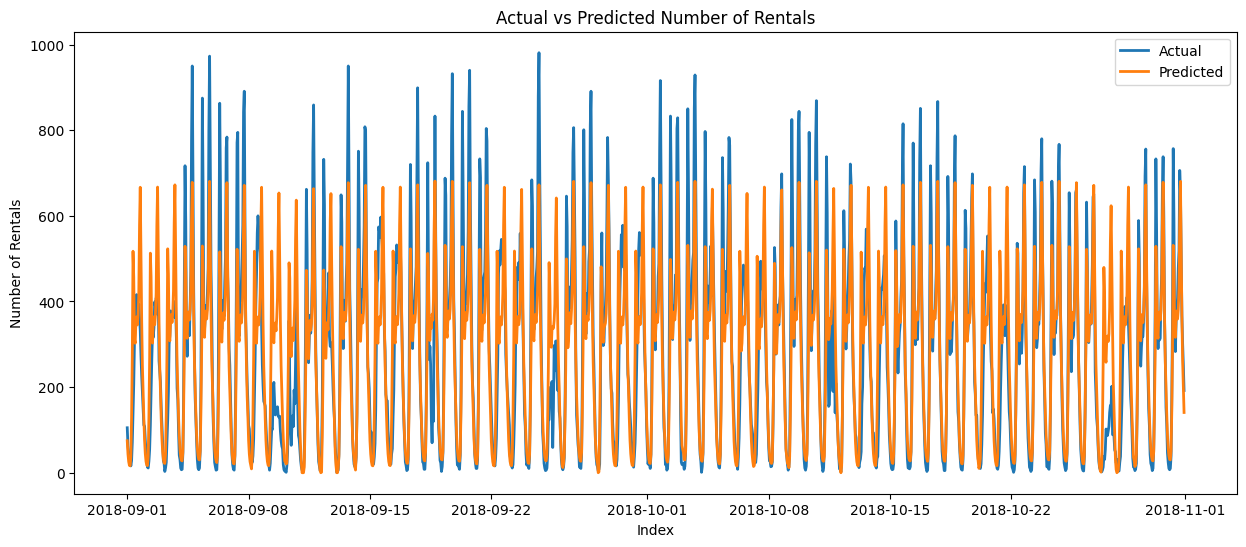

Mean Absolute Error (MAE): 79.33
Root Mean Squared Error (RMSE): 117.78


In [100]:
train_exog_w_date = train_weather[['precip','visibility', 'day_of_week', 'hour_of_day']]

train_exog_w_date['hour_sin'] = np.sin(2 * np.pi * train_exog_w_date['hour_of_day'] / 24)
train_exog_w_date['hour_cos'] = np.cos(2 * np.pi * train_exog_w_date['hour_of_day'] / 24)
train_exog_w_date = train_exog_w_date.drop('hour_of_day', axis=1)

train_exog_w_date['dow_sin'] = np.sin(2 * np.pi * train_exog_w_date['day_of_week'] / 7)
train_exog_w_date['dow_cos'] = np.cos(2 * np.pi * train_exog_w_date['day_of_week'] / 7)
train_exog_w_date = train_exog_w_date.drop('day_of_week', axis=1)

test_exog_w_date = test_weather[['precip','visibility', 'day_of_week', 'hour_of_day']]

test_exog_w_date['hour_sin'] = np.sin(2 * np.pi * test_exog_w_date['hour_of_day'] / 24)
test_exog_w_date['hour_cos'] = np.cos(2 * np.pi * test_exog_w_date['hour_of_day'] / 24)
test_exog_w_date = test_exog_w_date.drop('hour_of_day', axis=1)

test_exog_w_date['dow_sin'] = np.sin(2 * np.pi * test_exog_w_date['day_of_week'] / 7)
test_exog_w_date['dow_cos'] = np.cos(2 * np.pi * test_exog_w_date['day_of_week'] / 7)
test_exog_w_date = test_exog_w_date.drop('day_of_week', axis=1)



print(f'Prediciting {PICKUP_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, PICKUP_TARGET_COL, order,s_order, train_exog_w_date)
performance_pickup["model_sarimax_short_w_date"] = {"val_mae": mae, "val_rmse": rmse}

print(f'Prediciting {DROPOFF_TARGET_COL}')
mae, rmse = sarimax_fit_predict_folds_daily(folds_config, train_data, DROPOFF_TARGET_COL, order,s_order, train_exog_w_date)
performance_dropoffs["model_sarimax_short_w_date"] = {"val_mae": mae, "val_rmse": rmse}

# NN

In [202]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [203]:
def get_dataset(hourly_cluster,n_lags, forecast_horizon, target):
    train_data_nn = hourly_cluster.set_index('datetime')
    # --- Create lag features ---
    df = train_data_nn[[target]].copy()
    lags= {f'target_lag_{lag}': df[target].shift(lag) for lag in range(1, n_lags+1)}
    lags_df = pd.DataFrame(lags, index=df.index)
    df = pd.concat([df, lags_df], axis=1)

    exog_features = ['day_of_week','hour_of_day', 'precip', 'visibility']
    df[exog_features] = weather_cleaned.set_index('datetime')[exog_features].loc[df.index]
    df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df = df.drop(['day_of_week','hour_of_day'], axis=1)
    exog_features = ['precip', 'visibility','hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
    # --- Create multi-step target ---
    for step in range(1, forecast_horizon + 1):
        df[f'target_+{step}'] = df[target].shift(-step)

    # --- Drop rows with NaNs due to lags or forward targets ---
    all_columns = [f'target_lag_{lag}' for lag in range(1, n_lags + 1)] + exog_features + \
              [f'target_+{step}' for step in range(1, forecast_horizon + 1)]

    df = df.dropna(subset=all_columns)
    # --- Keep only rows at midnight (00:00) for end-of-day prediction ---
    df = df[df.index.hour == 0]

    return df

# --- Parameters ---
n_lags = 168        # previous week of hourly data
forecast_horizon = 24  # next 24 hours

df_pickup = get_dataset(hourly_cluster, n_lags, forecast_horizon, PICKUP_TARGET_COL)
df_dropoff =get_dataset(hourly_cluster, n_lags, forecast_horizon, DROPOFF_TARGET_COL)

In [204]:
def split_datesets(df, END_TRAINING_DATE, END_VALIDATION_DATE, target, exog_features, forecast_horizon):

    X = df[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y = df[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values

    X_train = X[df.index < END_TRAINING_DATE]
    y_train = y[df.index < END_TRAINING_DATE]

    X_val = X[(df.index >= END_TRAINING_DATE) & (df.index < END_VALIDATION_DATE)]
    y_val = y[(df.index >= END_TRAINING_DATE) & (df.index < END_VALIDATION_DATE)]

    X_train_final = X[df.index < END_VALIDATION_DATE]
    y_train_final = y[df.index < END_VALIDATION_DATE]

    X_test = X[df.index >= END_VALIDATION_DATE]
    y_test = y[df.index >= END_VALIDATION_DATE]

    return X_train, y_train, X_val, y_val, X_train_final, y_train_final, X_test, y_test

exog_features = ['precip', 'visibility','hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

X_p_train, y_p_train, X_p_val, y_p_val, X_p_train_final, y_p_train_final, X_p_test, y_p_test = split_datesets(df_pickup, END_TRAINING_DATE, END_VALIDATION_DATE,PICKUP_TARGET_COL,exog_features,forecast_horizon)

X_d_train, y_d_train, X_d_val, y_d_val, X_d_train_final, y_d_train_final, X_d_test, y_d_test = split_datesets(df_dropoff, END_TRAINING_DATE, END_VALIDATION_DATE,DROPOFF_TARGET_COL,exog_features,forecast_horizon)

In [205]:
from sklearn.preprocessing import StandardScaler

# Pickups
scaler_pickup = StandardScaler()
X_pickup_train_scaled = scaler_pickup.fit_transform(X_p_train)
X_pickup_val_scaled = scaler_pickup.transform(X_p_val)

# Dropoffs
scaler_dropoff = StandardScaler()
X_dropoff_train_scaled = scaler_dropoff.fit_transform(X_d_train)
X_dropoff_val_scaled = scaler_dropoff.transform(X_d_val)

In [206]:
from tensorflow.keras.callbacks import EarlyStopping

def create_nn_and_train(X_train_scaled, y_train):

    model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(forecast_horizon) 
        ])
    
    model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=24,
        callbacks=[early_stop],
        verbose=0
    )
    return model

def predict_nn(model, X_val_scaled, y_val, val_start, val_end):
    y_pred = model.predict(X_val_scaled)
    y_pred = np.clip(y_pred, 0, None)

    # Flatten for all predictions
    y_val_flat = y_val.flatten()
    y_pred_flat = y_pred.flatten()

    # Metrics
    mae, rmse = print_metrics(y_val_flat, y_pred_flat)

    hourly_index = pd.date_range(start=val_start, end=val_end, freq='h')

    df_hourly_val = pd.DataFrame(index=hourly_index)
    df_hourly_val["y_pred"] = y_pred_flat
    df_hourly_val["y_true"] = y_val_flat
    plot_predictions_vs_true(df_hourly_val["y_pred"], df_hourly_val["y_true"])
    return y_val_flat, y_pred_flat, mae, rmse


In [207]:
val_start = pd.Timestamp('2018-09-01 00:00:00')
val_end   = pd.Timestamp('2018-10-31 23:00:00')  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Mean Absolute Error (MAE): 68.49
Root Mean Squared Error (RMSE): 117.12


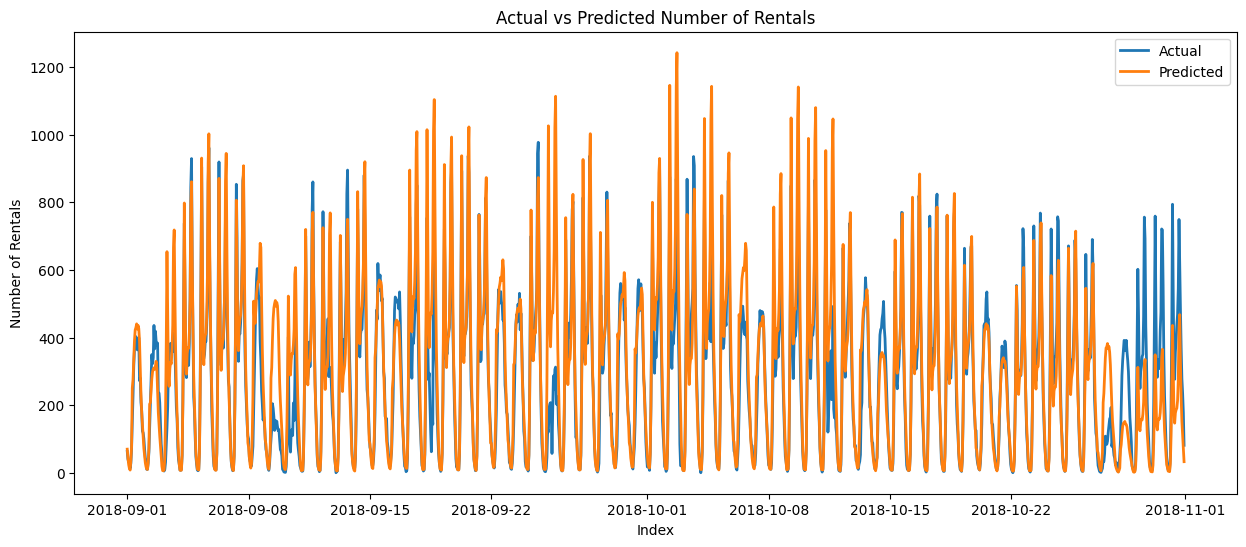

In [208]:
p_train_model = create_nn_and_train(X_pickup_train_scaled, y_p_train)
y_val_flat, y_pred_flat, mae_p_train, rmse_p_train = predict_nn(p_train_model, X_pickup_val_scaled, y_p_val, val_start, val_end)

performance_pickup["model_nn"] = {"val_mae": np.round(np.mean(mae_p_train),2), "val_rmse": np.round(np.mean(rmse_p_train),2)}

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Mean Absolute Error (MAE): 68.5
Root Mean Squared Error (RMSE): 114.92


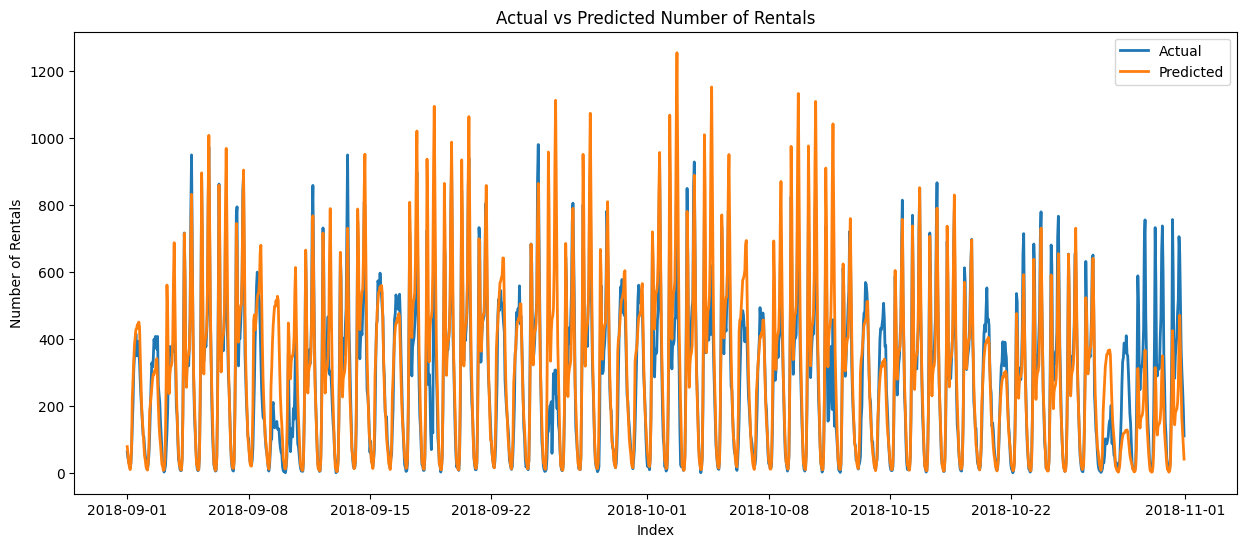

In [209]:
d_train_model = create_nn_and_train(X_dropoff_train_scaled, y_d_train)
y_val_flat_d, y_pred_flat_d, mae_d_train, rmse_d_train = predict_nn(d_train_model, X_dropoff_val_scaled, y_d_val, val_start, val_end)
performance_dropoffs["model_nn"] = {"val_mae": np.round(np.mean(mae_d_train),2), "val_rmse": np.round(np.mean(rmse_d_train),2)}

In [210]:
performance_pickup, performance_dropoffs

({'model_sarima': {'val_mae': 77.02, 'val_rmse': 117.16},
  'model_sarimax': {'val_mae': 80.28, 'val_rmse': 117.74},
  'model_sarimax_short': {'val_mae': 76.56, 'val_rmse': 116.42},
  'model_sarimax_short_w_date': {'val_mae': 76.51, 'val_rmse': 115.66},
  'model_nn': {'val_mae': 68.49, 'val_rmse': 117.12}},
 {'model_sarima': {'val_mae': 75.5, 'val_rmse': 115.49},
  'model_sarimax': {'val_mae': 78.89, 'val_rmse': 114.82},
  'model_sarimax_short': {'val_mae': 74.65, 'val_rmse': 114.0},
  'model_sarimax_short_w_date': {'val_mae': 74.31, 'val_rmse': 112.76},
  'model_nn': {'val_mae': 68.5, 'val_rmse': 114.92}})

## Performance of best model in test set

### Pick ups

In [211]:
scaler_pickup = StandardScaler()
X_pickup_final_scaled = scaler_pickup.fit_transform(X_p_train_final)
X_pickup_test_scaled = scaler_pickup.transform(X_p_test)

In [212]:
val_start = pd.Timestamp('2018-11-01 00:00:00')
val_end   = pd.Timestamp('2018-12-30 23:00:00')  

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Mean Absolute Error (MAE): 67.25
Root Mean Squared Error (RMSE): 99.84


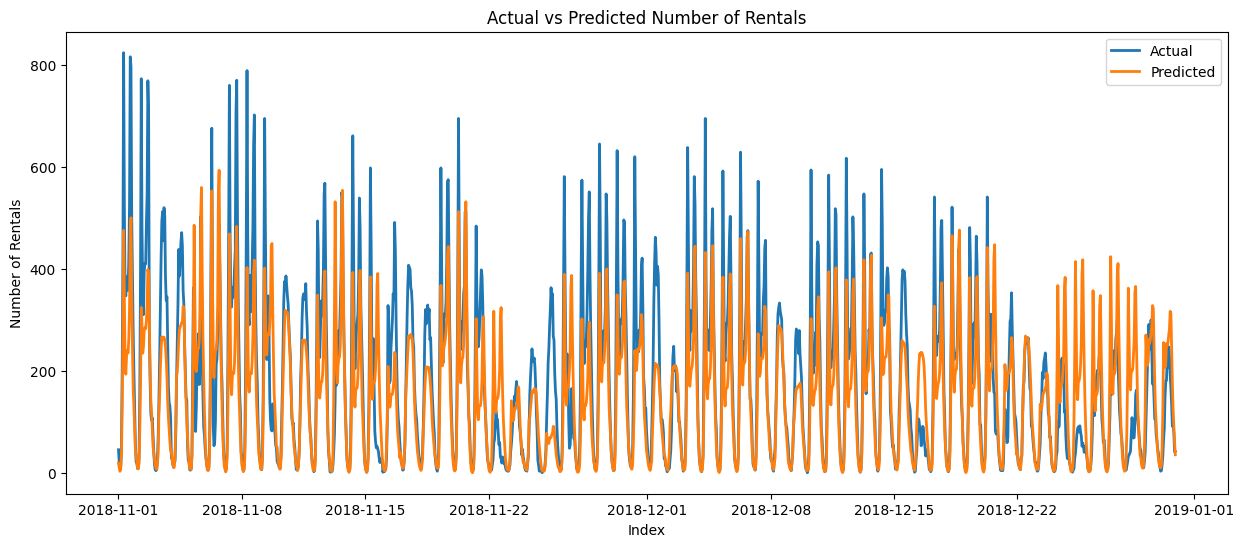

In [213]:
p_final_model = create_nn_and_train(X_pickup_final_scaled, y_p_train_final)
y_val_flat_final, y_pred_flat_final, mae_p_final, rmse_p_final = predict_nn(p_final_model, X_pickup_test_scaled, y_p_test, val_start, val_end)

### Drop Offs

In [214]:
scaler_dropoff = StandardScaler()
X_dropoff_final_scaled = scaler_dropoff.fit_transform(X_d_train_final)
X_dropoff_test_scaled = scaler_dropoff.transform(X_d_test)

/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Mean Absolute Error (MAE): 68.33
Root Mean Squared Error (RMSE): 99.29


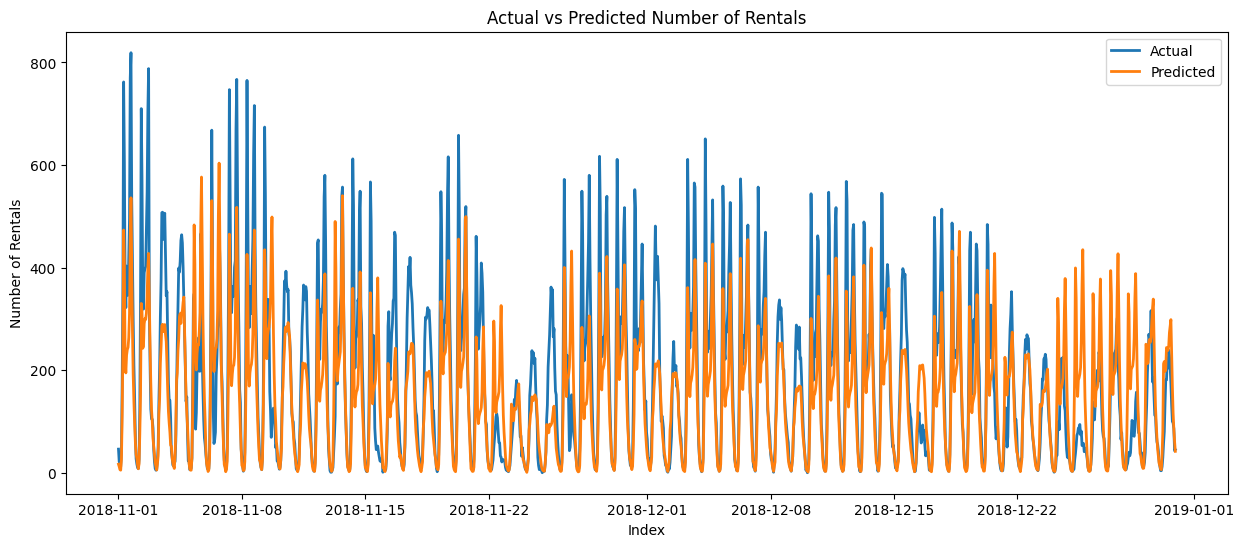

In [215]:
d_final_model = create_nn_and_train(X_dropoff_final_scaled, y_d_train_final)
y_val_flat_d_final, y_pred_flat_d_final, mae_d_final, rmse_d_final = predict_nn(d_final_model, X_dropoff_test_scaled, y_d_test, val_start, val_end)

# Task 3

In [216]:
required_bikes_per_cluster={}

for cluster_id in avg_bikes_per_cluster["station_cluster"]:
    cluster = data[data['station_cluster'] == cluster_id]
    print(f'cluster_id: {cluster_id}')
    #create hourly cluster dataset
    hourly_pickups_cluster = cluster.groupby(['pickup_datetime'])['bikeid'].size().reset_index(name='num_rentals')
    hourly_dropoffs_cluster = cluster.groupby(['dropoff_datetime'])['bikeid'].size().reset_index(name='num_rentals')
    hourly_cluster = pd.merge(hourly_pickups_cluster, hourly_dropoffs_cluster, left_on='pickup_datetime', right_on='dropoff_datetime', how='outer', suffixes=('_pickups', '_dropoffs')).drop(columns=['dropoff_datetime']).rename(columns={'pickup_datetime': 'datetime'})
    hourly_cluster['datetime'] = pd.to_datetime(hourly_cluster['datetime'])
    hourly_cluster = hourly_cluster[hourly_cluster['datetime'] < '2019-01-01']
    
    #fill empty timestamps
    print(f'size of hourly_cluster: {hourly_cluster.shape}')
    hourly_cluster = fill_missing_hours(hourly_cluster)
    print(f'size of hourly_cluster after filling missing hours: {hourly_cluster.shape}')

    train_data = hourly_cluster.set_index('datetime')
    train_data.index = pd.to_datetime(train_data.index)

    df_pickup = get_dataset(hourly_cluster, n_lags, forecast_horizon, PICKUP_TARGET_COL)
    df_dropoff =get_dataset(hourly_cluster, n_lags, forecast_horizon, DROPOFF_TARGET_COL)

    #use the last day for prediction  
    last_pickup =  df_pickup.iloc[-1].copy()
    df_pickup_train = df_pickup.iloc[:-1].copy()
    last_dropoff =  df_dropoff.iloc[-1].copy()
    df_dropoff_train = df_dropoff.iloc[:-1].copy()

    #select only relevant features
    X_pickup = df_pickup_train[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y_pickup = df_pickup_train[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values
    last_pickup_to_predict = last_pickup[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values.reshape(1, -1)
  
    X_dropoff = df_dropoff_train[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values
    y_dropoff = df_dropoff_train[[f'target_+{step}' for step in range(1, forecast_horizon+1)]].values
    last_dropoff_to_predict = last_dropoff[[f'target_lag_{lag}' for lag in range(1, n_lags+1)] + exog_features].values.reshape(1, -1)

    scaler_pickup = StandardScaler()
    X_pickup_train_scaled = scaler_pickup.fit_transform(X_pickup)
    last_pickup_to_predict_scaled = scaler_pickup.transform(last_pickup_to_predict)

    scaler_dropoff = StandardScaler()
    X_dropoff_train_scaled = scaler_dropoff.fit_transform(X_dropoff)
    last_dropoff_to_predict_scaled = scaler_dropoff.transform(last_dropoff_to_predict)
    #create and train models
    p_final_model = create_nn_and_train(X_pickup_train_scaled, y_pickup)
    d_final_model = create_nn_and_train(X_dropoff_train_scaled, y_dropoff)
    #get predictions
    p_pred = np.round(np.clip(p_final_model.predict(last_pickup_to_predict_scaled), 0, None))
    d_pred = np.round(np.clip(d_final_model.predict(last_dropoff_to_predict_scaled), 0 ,None))
    #find cumulative net
    cum_net = np.cumsum(d_pred - p_pred)
    required_bikes = max(0, -cum_net.min())
    required_bikes_per_cluster[cluster_id] = required_bikes

cluster_id: 11
size of hourly_cluster: (8721, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 22
size of hourly_cluster: (8725, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
cluster_id: 26
size of hourly_cluster: (8699, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
cluster_id: 1
size of hourly_cluster: (8710, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 8
size of hourly_cluster: (8620, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
cluster_id: 5
size of hourly_cluster: (8644, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 16
size of hourly_cluster: (8713, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
cluster_id: 4
size of hourly_cluster: (8675, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
cluster_id: 13
size of hourly_cluster: (8523, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
cluster_id: 17
size of hourly_cluster: (8485, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
cluster_id: 27
size of hourly_cluster: (8470, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 3
size of hourly_cluster: (8401, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
cluster_id: 12
size of hourly_cluster: (8292, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
cluster_id: 24
size of hourly_cluster: (8428, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 21
size of hourly_cluster: (8379, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
cluster_id: 18
size of hourly_cluster: (8285, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
cluster_id: 6
size of hourly_cluster: (8297, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 25
size of hourly_cluster: (8381, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
cluster_id: 23
size of hourly_cluster: (7860, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
cluster_id: 7
size of hourly_cluster: (8301, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
cluster_id: 20
size of hourly_cluster: (8248, 3)
size of hourly_cluster after filling missing hours: (8760, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
cluster_id: 15
size of hourly_cluster: (8057, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
cluster_id: 2
size of hourly_cluster: (8249, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
cluster_id: 14
size of hourly_cluster: (8096, 3)
size of hourly_cluster after filling missing hours: (8758, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
cluster_id: 9
size of hourly_cluster: (7959, 3)
size of hourly_cluster after filling missing hours: (8759, 3)


/Users/germa/anaconda3/envs/thesis/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [224]:
sorted_list = sorted(required_bikes_per_cluster.items(), key=lambda x: x[0])
sorted_list

[(1, 0),
 (2, 8.0),
 (3, 233.0),
 (4, 0),
 (5, 74.0),
 (6, 67.0),
 (7, 50.0),
 (8, 22.0),
 (9, 25.0),
 (11, 53.0),
 (12, 2.0),
 (13, 105.0),
 (14, 47.0),
 (15, 27.0),
 (16, 0),
 (17, 186.0),
 (18, 0),
 (20, 13.0),
 (21, 0),
 (22, 87.0),
 (23, 43.0),
 (24, 10.0),
 (25, 20.0),
 (26, 77.0),
 (27, 0)]